<a href="https://colab.research.google.com/github/christopher-reed/tidytuesday/blob/master/2020/week_30/code/TidyTuesday_Australia_Animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as fm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Read and clean**

In [7]:
# Read in data
animal_outcomes = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-07-21/animal_outcomes.csv')
animal_complaints = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-07-21/animal_complaints.csv')
brisbane_complaints = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-07-21/brisbane_complaints.csv')

# Clean column names
def col_cleaner(df):
  columns = {c: c.lower().replace(' ', '_') for c in df.columns}
  df = df.rename(columns = columns)
  return df

animal_outcomes = col_cleaner(animal_outcomes)
animal_complaints = col_cleaner(animal_complaints)
brisbane_complaints = col_cleaner(brisbane_complaints)

# Add row to animal outcomes for formatting
extra_row = pd.DataFrame([[1999, 'Wildlife','Reclaimed', 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [1999, 'Wildlife', 'Rehomed', 0, 0, 0, 0, 0, 0, 0, 0, 0],
                         [1999, 'Dogs', 'Released', 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [1999, 'Cats', 'Released', 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [1999, 'Horses','Released', 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [1999, 'Livestock', 'Released', 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [1999, 'Other Animals', 'Released', 0, 0, 0, 0, 0, 0, 0, 0, 0]],
                         columns= animal_outcomes.columns)
animal_outcomes = pd.concat([animal_outcomes, extra_row])

# Group by outcome and animal type to find the sum of animals that experienced each outcome in each region.
outcome_group = animal_outcomes.groupby(['outcome', 'animal_type']).sum().reset_index()

# Formatting
outcome_group = outcome_group.drop(columns = 'year')
outcome_group.loc['Total',:] = outcome_group[['act', 'nsw', 'nt', 'qld', 'sa', 'tas', 'vic', 'wa', 'total']].sum(axis = 0)

# Inspect
outcome_group.head()

,outcome,animal_type,act,nsw,nt,qld,sa,tas,vic,wa,total
0,Currently In Care,Cats,985.0,7599.0,3607.0,9772.0,3498.0,1923.0,7489.0,773.0,35646.0
1,Currently In Care,Dogs,609.0,6063.0,2839.0,7457.0,1832.0,897.0,5103.0,853.0,25653.0
2,Currently In Care,Horses,4.0,394.0,306.0,134.0,43.0,91.0,304.0,109.0,1385.0
3,Currently In Care,Livestock,161.0,1004.0,208.0,641.0,202.0,638.0,322.0,124.0,3300.0
4,Currently In Care,Other Animals,569.0,774.0,409.0,1345.0,771.0,233.0,1464.0,184.0,5752.0


In [5]:
# Collect data as lists for easy plotting
# Each region has an outer and inner list. The outer is the total number of each different outcome in that region.
# The inner is the number of different animals in that region that experienced a specific outcome.

act_outer = []
act_inner = []

nsw_outer = []
nsw_inner = []

nt_outer = []
nt_inner = []

qld_outer = []
qld_inner = []

sa_outer = []
sa_inner = []

tas_outer = []
tas_inner = []

vic_outer = []
vic_inner = []

wa_outer = []
wa_inner = []

outcomes = np.ndarray.tolist(outcome_group['outcome'].unique()[:-1])
animals = np.ndarray.tolist(outcome_group['animal_type'].unique()[:-1])

for i in outcomes:
  df = outcome_group[outcome_group['outcome'] == i]
  df_sum = outcome_group[outcome_group['outcome'] == i].sum()

  act_outer.append(df_sum.loc['act'])
  nsw_outer.append(df_sum.loc['nsw'])
  nt_outer.append(df_sum.loc['nt'])
  qld_outer.append(df_sum.loc['qld'])
  sa_outer.append(df_sum.loc['sa'])
  tas_outer.append(df_sum.loc['tas'])
  vic_outer.append(df_sum.loc['vic'])
  wa_outer.append(df_sum.loc['wa'])

  for j in animals:
    
    act_inner.append(df.loc[df['animal_type'] == j, 'act'].values[0])
    nsw_inner.append(df.loc[df['animal_type'] == j, 'nsw'].values[0])
    nt_inner.append(df.loc[df['animal_type'] == j, 'nt'].values[0])
    qld_inner.append(df.loc[df['animal_type'] == j, 'qld'].values[0])
    sa_inner.append(df.loc[df['animal_type'] == j, 'sa'].values[0])
    tas_inner.append(df.loc[df['animal_type'] == j, 'tas'].values[0])
    vic_inner.append(df.loc[df['animal_type'] == j, 'vic'].values[0])
    wa_inner.append(df.loc[df['animal_type'] == j, 'wa'].values[0])


In [6]:
# Collect the total number of animals handled by RSPCA in each region
totals = pd.DataFrame(outcome_group.loc['Total', ['act', 'nsw', 'nt', 'qld', 'sa', 'tas', 'vic', 'wa']]).sort_values(by = 'Total')

# Scale the radius of each pie chart to a new range
old_range = (totals['Total'].max() - totals['Total'].min())

# Range of radius determined through trial and error
new_range = 2.8 - 1.7

# Store scaled values
scaled_nums = []

# Loop through each region's total number of animals and scale to desired range
for i in totals['Total']:
  new_num = (((i - totals['Total'].min()) * new_range) / old_range) + 1.7
  scaled_nums.append(new_num)

# Add a new column to totals df
totals['scaled_radius'] = scaled_nums

# Inspect
totals.head()

,Total,scaled_radius
wa,58746,1.700000
tas,93670,1.748157
act,134076,1.803873
nt,137636,1.808781
sa,210728,1.909568


# Plotting

In [8]:
# Prepare to plot

#Supress output
%%capture

#Set the font
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
matplotlib.rc('font', family='TH Sarabun New')

#Function to read and plot image
def getImage(path):
    return OffsetImage(plt.imread(path))

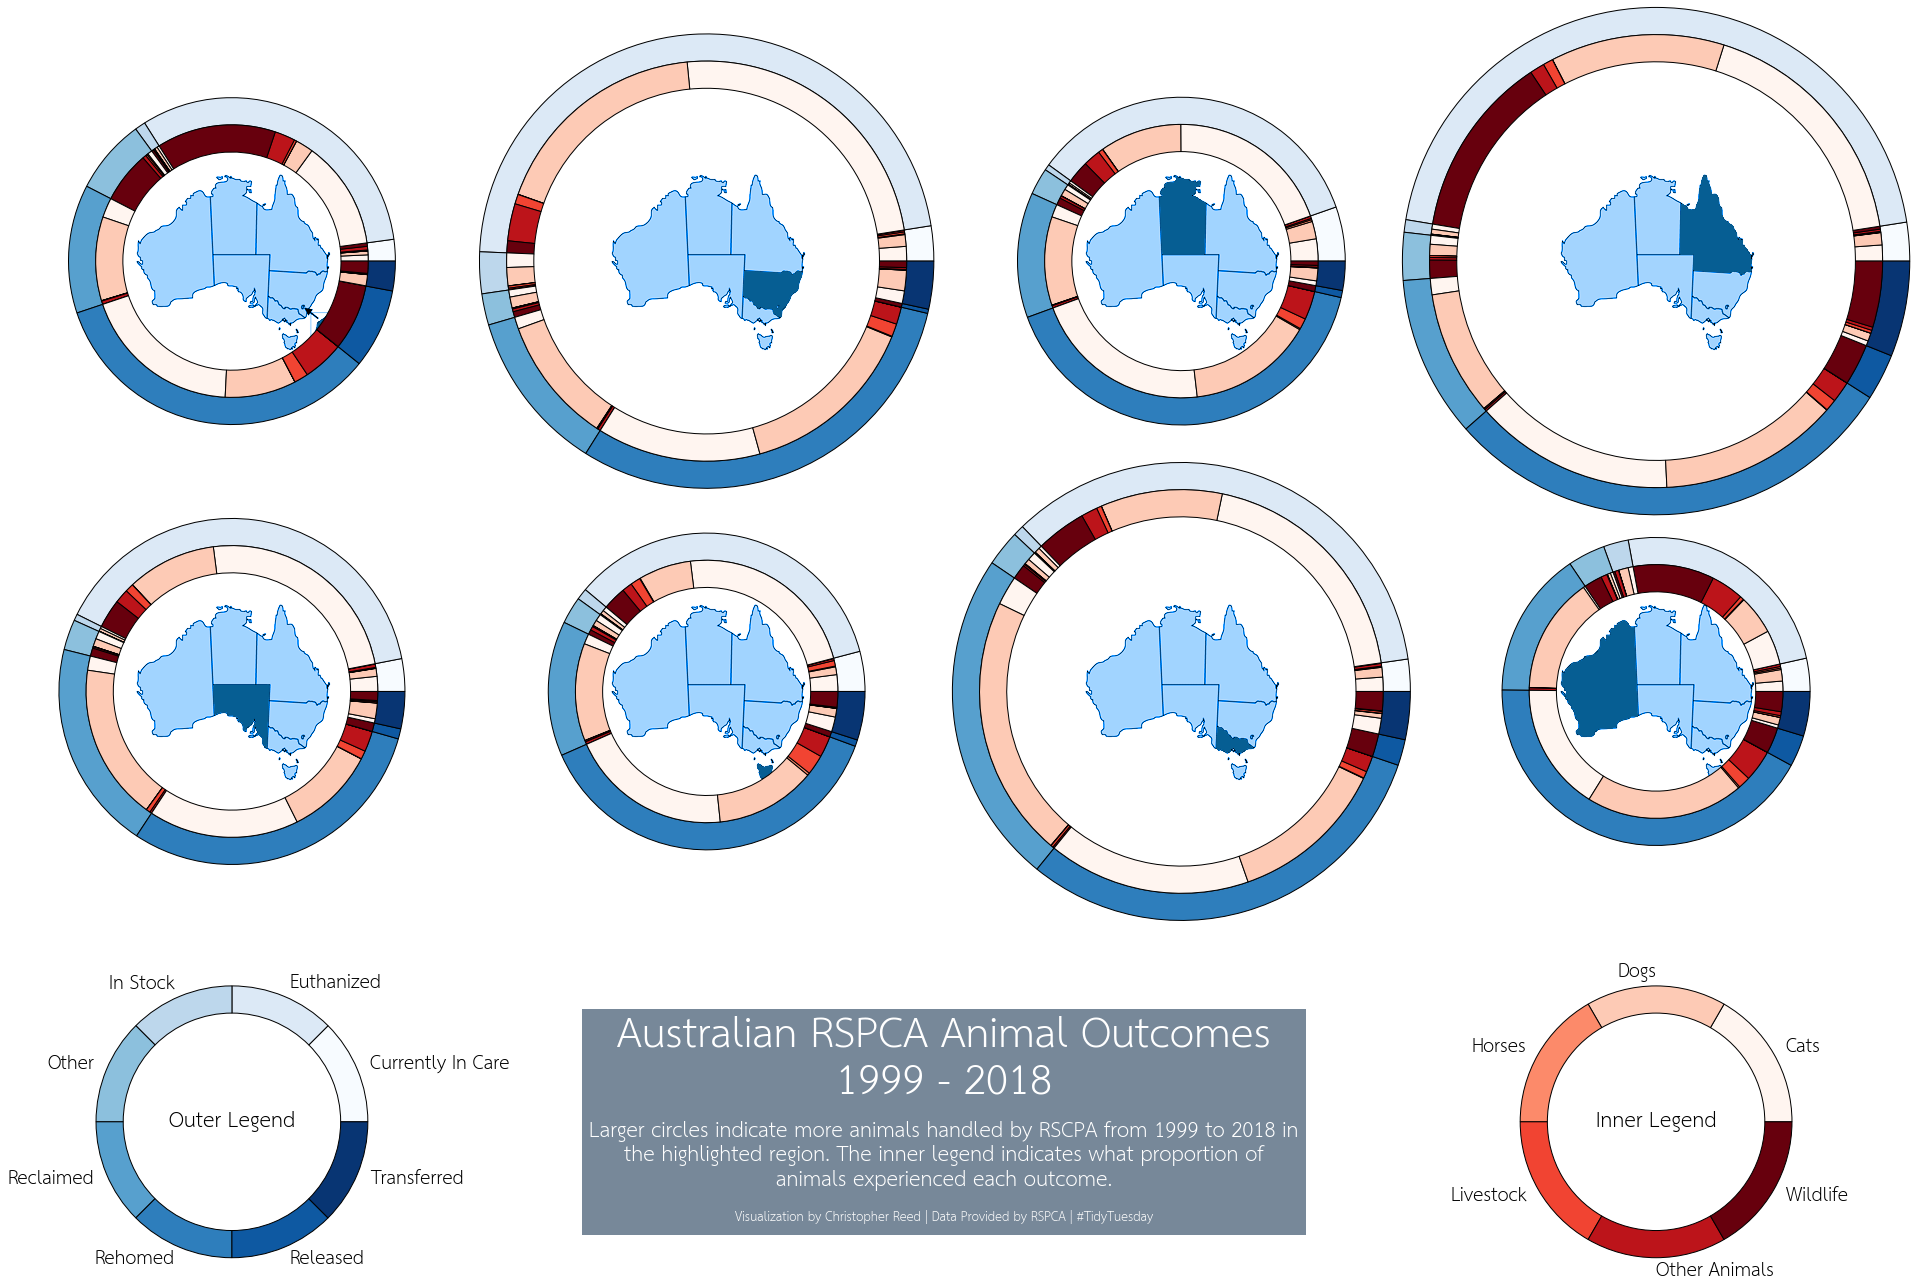

In [13]:
##########################
##SET UP FIGURE AND AXES##
##########################
fig = plt.figure(figsize = (30,20))

#Gridspec allows me to combine two subplots together which will be useful when adding a title and text.
gs = fig.add_gridspec(3,4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[1,0])
ax6 = fig.add_subplot(gs[1,1])
ax7 = fig.add_subplot(gs[1,2])
ax8 = fig.add_subplot(gs[1,3])
ax9 = fig.add_subplot(gs[2,0])

#Combine the 10th and 11th subplot
ax10_11 = fig.add_subplot(gs[2,1:3])

ax12 = fig.add_subplot(gs[2,3])

#################
##COLOR PALETTE##
#################

outer_cmap = plt.cm.Blues
inner_cmap = plt.cm.Reds

outer_color_palette = [outer_cmap(0.0), outer_cmap(0.14), outer_cmap(0.28), outer_cmap(0.42), outer_cmap(0.56), outer_cmap(0.70), outer_cmap(0.84), outer_cmap(0.98)]
inner_color_palette = [inner_cmap(0.0), inner_cmap(0.2), inner_cmap(0.4), inner_cmap(0.6), inner_cmap(0.8), inner_cmap(1.0)]

#######
##ACT##
#######

#Outer ring
act_outer_pie, _ = ax1.pie(act_outer, radius = totals.loc['act', 'scaled_radius'], colors= outer_color_palette)
plt.setp(act_outer_pie, width=0.3, edgecolor='black')

#Inner ring
act_inner_pie, _ = ax1.pie(act_inner, radius = totals.loc['act', 'scaled_radius'] -0.3, labeldistance=0.7, colors= inner_color_palette)
plt.setp(act_inner_pie, width=0.3, edgecolor='black')

#Add image
ax1.add_artist(AnnotationBbox(getImage('/content/act_australia.gif'), (0,0), frameon = False)).set_zorder(-10)

#######
##NSW##
#######

#Outer ring
nsw_outer_pie, _ = ax2.pie(nsw_outer, radius= totals.loc['nsw', 'scaled_radius'], colors= outer_color_palette)
plt.setp(nsw_outer_pie, width=0.3, edgecolor='black')

#Inner ring
nsw_inner_pie, _ = ax2.pie(nsw_inner, radius = totals.loc['nsw', 'scaled_radius']-0.3, labeldistance=0.7, colors= inner_color_palette)
plt.setp(nsw_inner_pie, width=0.3, edgecolor='black')

#Add image
ax2.add_artist(AnnotationBbox(getImage('/content/nsw_australia.gif'), (0,0), frameon = False)).set_zorder(-10)

#######
##NT###
#######

#Outer ring
nt_outer_pie, _ = ax3.pie(nt_outer, radius= totals.loc['nt', 'scaled_radius'], colors= outer_color_palette)
plt.setp(nt_outer_pie, width=0.3, edgecolor='black')

#Inner ring
nt_inner_pie, _ = ax3.pie(nt_inner, radius= totals.loc['nt', 'scaled_radius']-0.3, labeldistance=0.7, colors= inner_color_palette)
plt.setp(nt_inner_pie, width=0.3, edgecolor='black')

#Image
ax3.add_artist(AnnotationBbox(getImage('/content/northern_territory_australia.gif'), (0,0), frameon = False)).set_zorder(-10)

#######
##QLD##
#######

#Outer ring
qld_outer_pie, _ = ax4.pie(qld_outer, radius= totals.loc['qld', 'scaled_radius'], colors= outer_color_palette)
plt.setp(qld_outer_pie, width = 0.3, edgecolor='black')

#Inner ring
qld_inner_pie, _ = ax4.pie(qld_inner, radius= totals.loc['qld', 'scaled_radius']-0.3, labeldistance=0.7, colors= inner_color_palette)
plt.setp(qld_inner_pie, width=0.3, edgecolor='black')

#Image
ax4.add_artist(AnnotationBbox(getImage('/content/queensland.gif'), (0,0), frameon = False)).set_zorder(-10)

#######
##SA###
#######

#Outer ring
sa_outer_pie, _ = ax5.pie(sa_outer, radius= totals.loc['sa', 'scaled_radius'], colors= outer_color_palette)
plt.setp(sa_outer_pie, width=0.3, edgecolor='black')

#Inner ring
sa_inner_pie, _ = ax5.pie(sa_inner, radius=totals.loc['sa', 'scaled_radius']-0.3, labeldistance=0.7, colors= inner_color_palette)
plt.setp(sa_inner_pie, width=0.3, edgecolor='black')

#Add image
ax5.add_artist(AnnotationBbox(getImage('/content/south_australia.gif'), (0,0), frameon = False)).set_zorder(-10)

#######
##TAS##
#######

#Outer ring
tas_outer_pie, _ = ax6.pie(tas_outer, radius = totals.loc['tas', 'scaled_radius'], colors= outer_color_palette)
plt.setp(tas_outer_pie, width=0.3, edgecolor='black')

#Inner ring
tas_inner_pie, _ = ax6.pie(tas_inner, radius=totals.loc['tas', 'scaled_radius']-0.3, labeldistance=0.7, colors= inner_color_palette)
plt.setp(tas_inner_pie, width=0.3, edgecolor='black')

#Add image
ax6.add_artist(AnnotationBbox(getImage('/content/tasmania_australia.gif'), (0,0), frameon = False)).set_zorder(-10)

#######
##VIC##
#######

#Outer ring
vic_outer_pie, _ = ax7.pie(vic_outer, radius = totals.loc['vic', 'scaled_radius'], colors= outer_color_palette)
plt.setp(vic_outer_pie, width=0.3, edgecolor='black')

#Inner ring
vic_inner_pie, _ = ax7.pie(vic_inner, radius = totals.loc['vic', 'scaled_radius']-0.3, labeldistance=0.7, colors= inner_color_palette)
plt.setp(vic_inner_pie, width=0.3, edgecolor='black')

#Add image
ax7.add_artist(AnnotationBbox(getImage('/content/victoria_australia.gif'), (0,0), frameon = False)).set_zorder(-10)

#######
##WA###
#######

#Outer ring
wa_outer_pie, _ = ax8.pie(wa_outer, radius = totals.loc['wa', 'scaled_radius'], colors= outer_color_palette)
plt.setp(wa_outer_pie, width=0.3, edgecolor='black')

#Inner ring
wa_inner_pie, _ = ax8.pie(wa_inner, radius = totals.loc['wa', 'scaled_radius']-0.3, labeldistance=0.7, colors= inner_color_palette)
plt.setp(wa_inner_pie, width=0.3, edgecolor='black')

#Add image
ax8.add_artist(AnnotationBbox(getImage('/content/west_australia.gif'), (0,0), frameon = False)).set_zorder(-10)

##########
##LEGEND##
##########

#Collect lines for legends
outcomes_legend_lines = []
animals_legend_lines = []

#Outer legend lines
for i in range(len(outer_color_palette)):
  outcomes_legend_lines.append(Line2D([0], [0], color = outer_color_palette[i], lw = 8))


#Outer legend
outer_legend_pie, _ = ax9.pie([1/len(outcomes)]*len(outcomes),
                               radius = 1.5,
                               labels = outcomes,
                               colors = outer_color_palette,
                               textprops = {'fontsize': 18})

ax9.text(0,0,'Outer Legend', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20, weight = 'bold')

plt.setp(outer_legend_pie, width=0.3, edgecolor='black')

#Inner legend
inner_legend_pie, _ = ax12.pie([1/len(animals)]*len(animals),
                               radius = 1.5,
                               labels = animals,
                               colors = inner_color_palette,
                               textprops = {'fontsize': 18})

ax12.text(0,0,'Inner Legend', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20, weight = 'bold')

plt.setp(inner_legend_pie, width=0.3, edgecolor='black')

##################
##TITLE AND TEXT##
##################
ax10_11.text(0.5,1.0, 'Australian RSPCA Animal Outcomes\n1999 - 2018',
             fontsize = 40,
             color = 'white',
             weight = 'bold',
             horizontalalignment = 'center')

ax10_11.text(0.5, 0.35, 'Larger circles indicate more animals handled by RSCPA from 1999 to 2018 in\nthe highlighted region. The inner legend indicates what proportion of\nanimals experienced each outcome.',
             fontsize = 20,
             color = 'white',
             horizontalalignment = 'center')

ax10_11.text(0.5, 0.1, 'Visualization by Christopher Reed | Data Provided by RSPCA | #TidyTuesday',
             fontsize = 12,
             color = 'white',
             horizontalalignment = 'center')
ax10_11.set_ylim(top = 1.6)
ax10_11.set_facecolor('lightslategrey')

#Remove axis 
for i in ['right', 'top', 'left', 'bottom']:
  ax10_11.spines[i].set_visible(False)

#Remove ticks
ax10_11.get_xaxis().set_ticks([])
ax10_11.get_yaxis().set_ticks([])

################################
##ADJUST SPACING BETWEEN PLOTS##
################################

#Remove space between subplots
plt.subplots_adjust(wspace= 0.9, hspace=0.9)


###############
##SAVE FIGURE##
###############
plt.savefig('RSPCA_animal_outcomes.jpg', bbox_inches = 'tight')